In [1]:
%matplotlib inline
%load_ext autotime

import matplotlib as mpl
import matplotlib.pyplot as pt
import numpy as np
import pandas as pd
import sklearn as sk
import sklearn.metrics

In [2]:
import keras
import tensorflow as tf

Using TensorFlow backend.


time: 18.8 s


In [3]:
import libs.yellowfin as yf

time: 21 ms


In [4]:
mpl.rcParams[ 'figure.figsize' ] = ( 18, 3 )

time: 1.04 ms


In [5]:
class OptimizerWrapper( keras.optimizers.Optimizer ):
    def __init__( self, optimizer ):
        self.optimizer = optimizer
        self.updates = []
    def get_updates( self, params, constrains, loss ):
        grads = self.optimizer._optimizer.compute_gradients( loss, params, gate_gradients=yf.GATE_OP )
        opt_update = self.optimizer.apply_gradients( grads )
        self.updates.append( opt_update )
        return self.updates
    @property
    def weights( self ):
        raise NotImplementedError
    def get_config( self ):
        raise NotImplementedError
    def from_config( self ):
        raise NotImplementedError

time: 14.2 ms


# load data

In [6]:
from keras.datasets import mnist

( train_x, train_y ), ( test_x, test_y ) = mnist.load_data()
nn_train_x = train_x.astype( float ).reshape( train_x.shape[ 0 ], -1 )
nn_train_x = sk.preprocessing.MinMaxScaler().fit_transform( nn_train_x )
nn_train_y = keras.utils.to_categorical( train_y )
# test_x = test_x.astype( float ).reshape( test_x.shape[ 0 ], -1 )
# test_x = sk.preprocessing.MinMaxScaler().fit_transform( test_x )
# test_y = keras.utils.to_categorical( test_y )
nn_train_x.shape, nn_train_y.shape#, test_x.shape, test_y.shape

((60000, 784), (60000, 10))

time: 3.08 s


# parameters

In [7]:
hidden_dim = 128
batch_size = 10000
epochs = 500

time: 1.24 ms


# YellowFin

In [8]:
m1 = keras.models.Sequential()
m1.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'relu' ) )
m1.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m1.add( keras.layers.Activation( 'softmax' ) )
m1.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 134 ms


In [9]:
h1 = m1.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 7min 13s


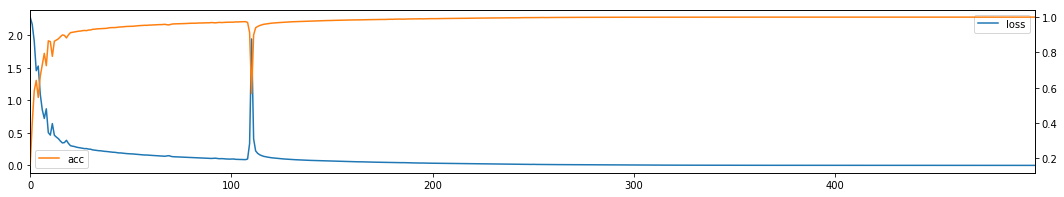

time: 315 ms


In [10]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h1.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h1.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [11]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.99998333333333334

time: 528 ms


In [12]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5841,    0,    0,    1,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 520 ms


In [13]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m1.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 418 ms


# stochastic gradient descent

In [14]:
m2 = keras.models.Sequential()
m2.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'relu' ) )
m2.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m2.add( keras.layers.Activation( 'softmax' ) )
m2.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 73.2 ms


In [15]:
h2 = m2.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 25s


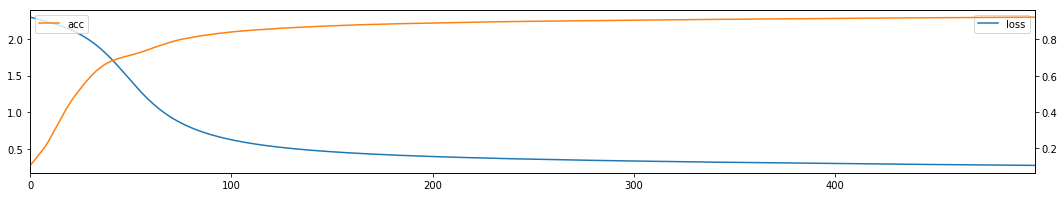

time: 259 ms


In [16]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h2.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h2.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [17]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.92215000000000003

time: 549 ms


In [18]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5727,    0,   30,   11,   13,   38,   38,    8,   50,    8],
       [   0, 6530,   38,   21,    8,   29,    6,   16,   83,   11],
       [  44,   61, 5359,   85,   76,   18,   99,   76,  116,   24],
       [  15,   39,  119, 5459,    4,  222,   27,   80,  114,   52],
       [  19,   34,   23,    3, 5446,    4,   61,    7,   25,  220],
       [  66,   29,   33,  164,   58, 4758,  105,   24,  124,   60],
       [  41,   22,   37,    0,   60,   83, 5649,    0,   26,    0],
       [  22,   41,   75,   24,   67,    7,    2, 5857,   15,  155],
       [  29,  110,   59,  129,   33,  141,   42,   13, 5213,   82],
       [  39,   31,   16,   78,  203,   38,    1,  170,   42, 5331]])

time: 552 ms


In [19]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m2.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.95      0.97      0.96      5923
          1       0.95      0.97      0.96      6742
          2       0.93      0.90      0.91      5958
          3       0.91      0.89      0.90      6131
          4       0.91      0.93      0.92      5842
          5       0.89      0.88      0.88      5421
          6       0.94      0.95      0.95      5918
          7       0.94      0.93      0.94      6265
          8       0.90      0.89      0.89      5851
          9       0.90      0.90      0.90      5949

avg / total       0.92      0.92      0.92     60000

time: 524 ms


# Adam

In [20]:
m3 = keras.models.Sequential()
m3.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'relu' ) )
m3.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m3.add( keras.layers.Activation( 'softmax' ) )
m3.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=[ 'acc' ] )

time: 67.5 ms


In [21]:
h3 = m3.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 36s


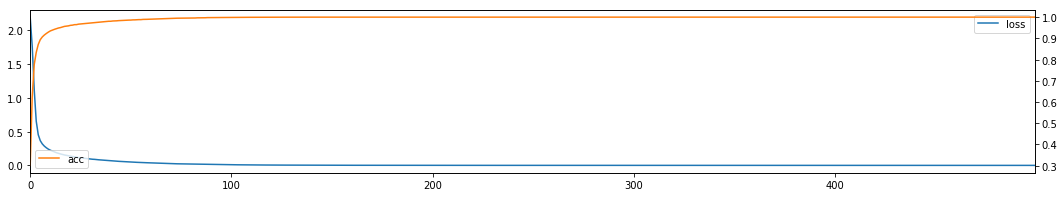

time: 295 ms


In [22]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h3.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h3.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [23]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 590 ms


In [24]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 597 ms


In [25]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m3.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 529 ms


# Nesterov Adam

In [26]:
m4 = keras.models.Sequential()
m4.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'relu' ) )
m4.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m4.add( keras.layers.Activation( 'softmax' ) )
m4.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 91.1 ms


In [27]:
h4 = m4.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 6min 30s


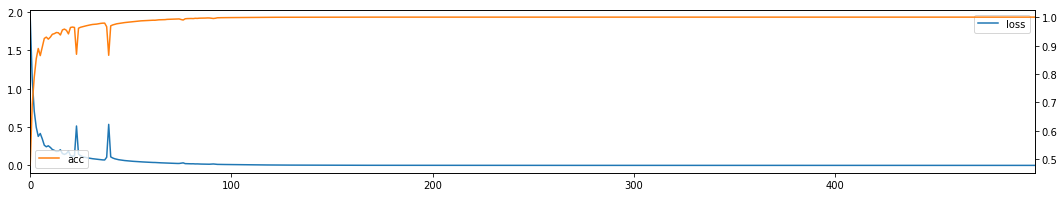

time: 322 ms


In [28]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h4.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h4.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [29]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 598 ms


In [30]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 594 ms


In [31]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m4.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 546 ms


# YellowFin (BN)

In [32]:
m5 = keras.models.Sequential()
m5.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.BatchNormalization() )
m5.add( keras.layers.Activation( 'relu' ) )
m5.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m5.add( keras.layers.Activation( 'softmax' ) )
m5.compile( loss='categorical_crossentropy', optimizer=OptimizerWrapper( yf.YFOptimizer() ), metrics=[ 'acc' ] )

time: 168 ms


In [33]:
h5 = m5.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 12min 8s


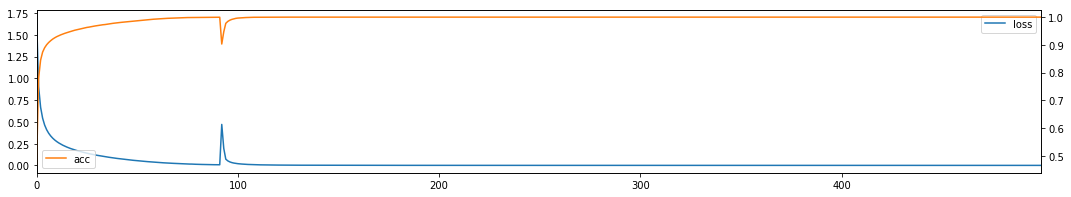

time: 503 ms


In [34]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h5.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h5.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [35]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 1.21 s


In [36]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 703 ms


In [37]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m5.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 607 ms


# stochastic gradient descent (BN)

In [38]:
m6 = keras.models.Sequential()
m6.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.BatchNormalization() )
m6.add( keras.layers.Activation( 'relu' ) )
m6.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m6.add( keras.layers.Activation( 'softmax' ) )
m6.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(), metrics=[ 'acc' ] )

time: 179 ms


In [39]:
h6 = m6.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 10min 37s


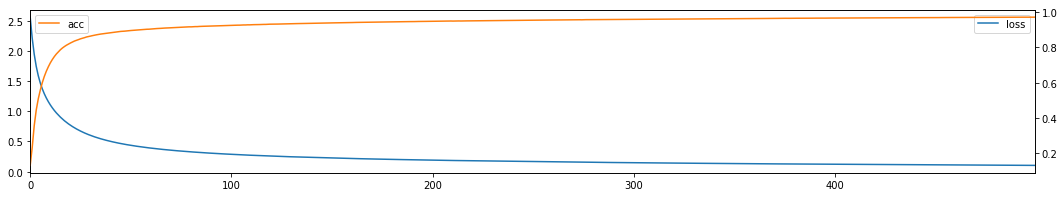

time: 338 ms


In [40]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h6.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h6.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [41]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

0.97243333333333337

time: 1.07 s


In [42]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5838,    0,   10,    2,    7,    9,   18,    3,   26,   10],
       [   1, 6652,   28,   15,    9,    5,    5,   10,   12,    5],
       [  17,   15, 5777,   30,   26,    6,   10,   36,   33,    8],
       [   7,   11,   54, 5900,    0,   53,    3,   32,   45,   26],
       [   7,   12,   17,    0, 5671,    3,   32,   12,   13,   75],
       [  11,    6,    9,   58,    9, 5237,   36,    6,   32,   17],
       [  21,    8,   10,    2,   11,   24, 5821,    1,   20,    0],
       [  12,   19,   41,    7,   25,    5,    1, 6103,    7,   45],
       [  13,   32,   23,   46,    9,   39,   20,    9, 5624,   36],
       [  19,    5,    2,   31,   68,   17,    3,   54,   27, 5723]])

time: 845 ms


In [43]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m6.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       0.98      0.99      0.98      5923
          1       0.98      0.99      0.99      6742
          2       0.97      0.97      0.97      5958
          3       0.97      0.96      0.97      6131
          4       0.97      0.97      0.97      5842
          5       0.97      0.97      0.97      5421
          6       0.98      0.98      0.98      5918
          7       0.97      0.97      0.97      6265
          8       0.96      0.96      0.96      5851
          9       0.96      0.96      0.96      5949

avg / total       0.97      0.97      0.97     60000

time: 789 ms


# Nesterov Adam (BN)

In [44]:
m7 = keras.models.Sequential()
m7.add( keras.layers.Dense( hidden_dim, input_shape=nn_train_x.shape[ 1: ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( hidden_dim, kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.BatchNormalization() )
m7.add( keras.layers.Activation( 'relu' ) )
m7.add( keras.layers.Dense( nn_train_y.shape[ 1 ], kernel_initializer='glorot_normal' ) )
m7.add( keras.layers.Activation( 'softmax' ) )
m7.compile( loss='categorical_crossentropy', optimizer=keras.optimizers.Nadam(), metrics=[ 'acc' ] )

time: 1.13 s


In [45]:
h7 = m7.fit( nn_train_x, nn_train_y, epochs=epochs, batch_size=batch_size, verbose=0 )

time: 10min 32s


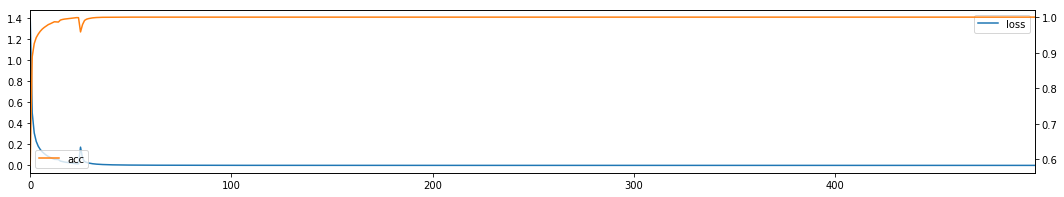

time: 408 ms


In [46]:
fig, ax1 = pt.subplots()
ax2 = ax1.twinx()
_ = pd.Series( h7.history[ 'loss' ], name='loss' ).plot.line( legend=True, ax=ax1, color='C0' )
_ = pd.Series( h7.history[ 'acc' ], name='acc' ).plot.line( legend=True, ax=ax2, color='C1' )

In [47]:
sk.metrics.accuracy_score( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

1.0

time: 1.11 s


In [48]:
sk.metrics.confusion_matrix( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) )

array([[5923,    0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0, 6742,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0, 5958,    0,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0, 6131,    0,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0, 5842,    0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0, 5421,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0, 5918,    0,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0, 6265,    0,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0, 5851,    0],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0, 5949]])

time: 987 ms


In [49]:
print( sk.metrics.classification_report( np.argmax( nn_train_y, 1 ), np.argmax( m7.predict( nn_train_x, batch_size=batch_size ), 1 ) ) )

             precision    recall  f1-score   support

          0       1.00      1.00      1.00      5923
          1       1.00      1.00      1.00      6742
          2       1.00      1.00      1.00      5958
          3       1.00      1.00      1.00      6131
          4       1.00      1.00      1.00      5842
          5       1.00      1.00      1.00      5421
          6       1.00      1.00      1.00      5918
          7       1.00      1.00      1.00      6265
          8       1.00      1.00      1.00      5851
          9       1.00      1.00      1.00      5949

avg / total       1.00      1.00      1.00     60000

time: 856 ms


# compare

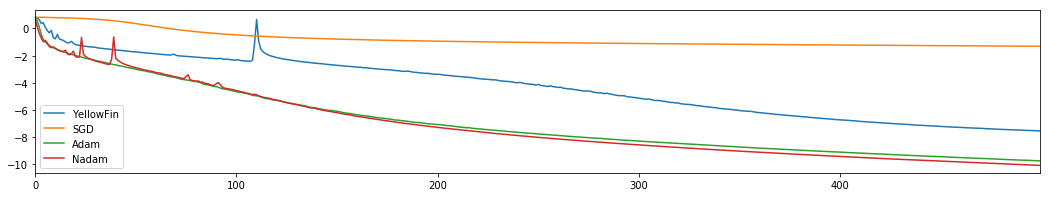

time: 290 ms


In [50]:
_ = pd.Series( np.log( h1.history[ 'loss' ] ), name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( np.log( h2.history[ 'loss' ] ), name='SGD' ).plot.line( legend=True )
_ = pd.Series( np.log( h3.history[ 'loss' ] ), name='Adam' ).plot.line( legend=True )
_ = pd.Series( np.log( h4.history[ 'loss' ] ), name='Nadam' ).plot.line( legend=True )

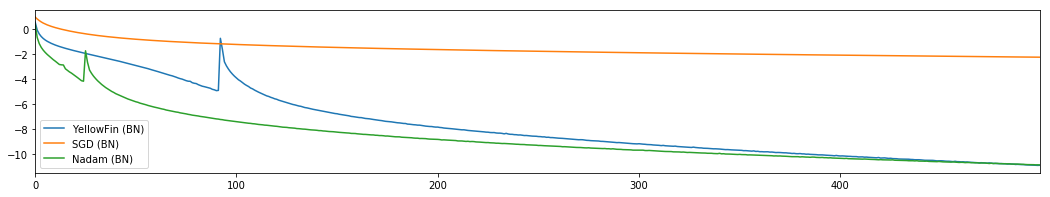

time: 263 ms


In [51]:
_ = pd.Series( np.log( h5.history[ 'loss' ] ), name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h6.history[ 'loss' ] ), name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( np.log( h7.history[ 'loss' ] ), name='Nadam (BN)' ).plot.line( legend=True )

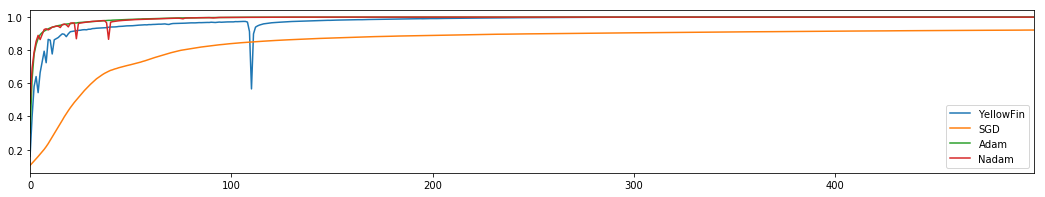

time: 308 ms


In [52]:
_ = pd.Series( h1.history[ 'acc' ], name='YellowFin' ).plot.line( legend=True )
_ = pd.Series( h2.history[ 'acc' ], name='SGD' ).plot.line( legend=True )
_ = pd.Series( h3.history[ 'acc' ], name='Adam' ).plot.line( legend=True )
_ = pd.Series( h4.history[ 'acc' ], name='Nadam' ).plot.line( legend=True )

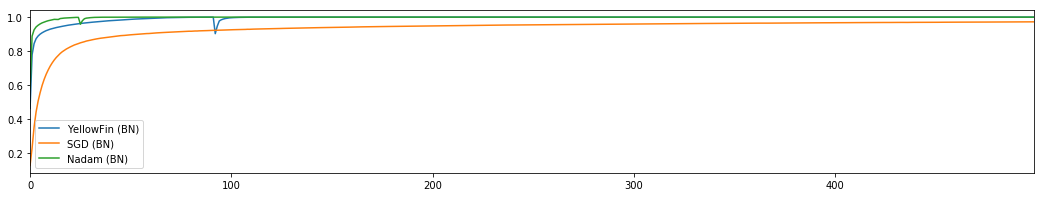

time: 248 ms


In [53]:
_ = pd.Series( h5.history[ 'acc' ], name='YellowFin (BN)' ).plot.line( legend=True )
_ = pd.Series( h6.history[ 'acc' ], name='SGD (BN)' ).plot.line( legend=True )
_ = pd.Series( h7.history[ 'acc' ], name='Nadam (BN)' ).plot.line( legend=True )